<a href="https://colab.research.google.com/github/i-suhas/Multi-Model-Classification/blob/main/MMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print("Path to dataset files:", path)
# from google.colab import files
# uploaded = files.upload()
import os

# List all files in the dataset folder
for file in os.listdir(path):
    print(file)


Path to dataset files: /kaggle/input/brazilian-ecommerce
olist_customers_dataset.csv
olist_sellers_dataset.csv
olist_order_reviews_dataset.csv
olist_order_items_dataset.csv
olist_products_dataset.csv
olist_geolocation_dataset.csv
product_category_name_translation.csv
olist_orders_dataset.csv
olist_order_payments_dataset.csv


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [30]:
input_dir =input_dir = "olist_order_reviews_dataset.csv"


# HYPERPARAMETERS
RANDOM_STATE = 12
TRAIN_SPLIT = 0.80
OOV_TOK = "<OOV>"
VOCAB_SIZE = 10000
EMBEDDING_DIM = 16
MAX_LENGTH = 120
BATCH_SIZE=128
EPOCHS=6
EARLY_STOPPING_CRITERIA=3
DROPOUT_P=0.4
LEARNING_RATE = 0.01
MOMENTUM =0.9
MAX_ITER = 10000
N_JOBS = 4

In [31]:
import pandas as pd

# Full path to the file
file_path = os.path.join(path, "olist_order_reviews_dataset.csv")

# Read into a DataFrame
data = pd.read_csv(file_path)

# Preview
data.head()


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [32]:
def clean_data(data, column_text='review_comment_message',
               column_score='review_score',
               points_cut = [0, 2, 5],
               classes = [0, 1]):

    df_bin = data
    df_bin = df_bin.dropna(subset=[column_text])
    df_bin['label'] = pd.cut(df_bin[column_score], bins=points_cut, labels=classes)
    df_bin = df_bin.rename(columns={column_text: 'text'})
    df_bin = df_bin[['text','label']]

    df_cat = data
    df_cat = df_cat.dropna(subset=[column_text])
    df_cat = df_cat.rename(columns={column_text: 'text' , column_score: 'label'})
    df_cat = df_cat[['text','label']]
    return df_bin ,df_cat


data_bin , data_cat = clean_data(data)

In [33]:
fig = px.bar(x = np.unique(data_cat["label"]),
             y = [list(data_cat["label"]).count(i) for i in np.unique(data_cat["label"])] ,
             color = np.unique(data_cat["label"]) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Ratings")
fig.update_yaxes(title = "Number of Reviews")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Rating vs No of reviews ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [34]:
fig = px.bar(x = np.unique(data_bin["label"]),
             y = [list(data_bin["label"]).count(i) for i in np.unique(data_bin["label"])] ,
             color=np.unique(data_bin["label"]) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Ratings")
fig.update_yaxes(title = "Number of Reviews")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Rating vs No of reviews ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [35]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

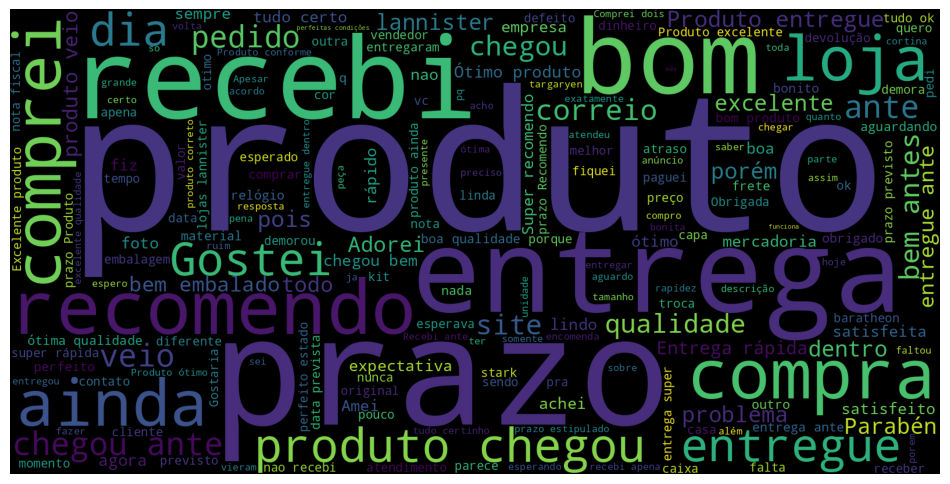

In [36]:
stop_words = stopwords.words('portuguese')
wordcloud = WordCloud(stopwords=stop_words,
                      background_color="black",
                      width=1600, height=800).generate(' '.join(data_bin["text"]))
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);

In [37]:
def split_test_train(data, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE):
    df_train = data.sample(frac = split_train, random_state = random_state)
    df_test = data.drop(df_train.index)

    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for index, train in df_train.iterrows():
        X_train.append(str(train['text']))
        y_train.append(train['label'])

    for index, test in df_test.iterrows():
        X_test.append(str(test['text']))
        y_test.append(test['label'])

    y_train = np.array(y_train)
    y_test = np.array(y_test)

    return X_train , y_train , X_test , y_test


X_train , y_train , X_test , y_test = split_test_train(data_bin, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE)

In [38]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(X_train)

def preprocess(X_train, X_test, max_length, vocab_size, trunc_type='post', oov_tok = "<OOV>"):

    training_sequences = tokenizer.texts_to_sequences(X_train)
    X_train_padded = pad_sequences(training_sequences,maxlen=max_length, truncating=trunc_type)

    testing_sequences = tokenizer.texts_to_sequences(X_test)
    X_test_padded = pad_sequences(testing_sequences,maxlen=max_length)

    return X_train_padded, X_test_padded

X_train, X_test = preprocess(X_train, X_test, MAX_LENGTH, VOCAB_SIZE)

In [40]:
def create_model():

    input = tf.keras.Input(shape=(MAX_LENGTH,)) # Changed this line

    x = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH)(input)
    x = tf.keras.layers.LSTM(32, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(32)(x)
    x = tf.keras.layers.Dropout(DROPOUT_P)(x)

    x = tf.keras.layers.Dense(800, activation='relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_P)(x)
    x = tf.keras.layers.Dense(400, activation='relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_P)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(input, output)

    return model

In [41]:

model=create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Call compile method on the model
history = model.fit(x = X_train,
                    y = y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks= [earlyStoppingCallback]
)
history = pd.DataFrame(history.history)

Epoch 1/6
257/257 ━━━━━━━━━━━━━━━━━━━━ 53s 189ms/step - accuracy: 0.7902 - loss: 0.4284 - val_accuracy: 0.8892 - val_loss: 0.2610
Epoch 2/6
257/257 ━━━━━━━━━━━━━━━━━━━━ 81s 187ms/step - accuracy: 0.9043 - loss: 0.2386 - val_accuracy: 0.8975 - val_loss: 0.2456
Epoch 3/6
257/257 ━━━━━━━━━━━━━━━━━━━━ 80s 179ms/step - accuracy: 0.9223 - loss: 0.2003 - val_accuracy: 0.8955 - val_loss: 0.2645
Epoch 4/6
257/257 ━━━━━━━━━━━━━━━━━━━━ 82s 179ms/step - accuracy: 0.9360 - loss: 0.1726 - val_accuracy: 0.8926 - val_loss: 0.2684
Epoch 5/6
257/257 ━━━━━━━━━━━━━━━━━━━━ 80s 171ms/step - accuracy: 0.9456 - loss: 0.1525 - val_accuracy: 0.8893 - val_loss: 0.2747
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [42]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

model = create_model()

model.compile(
  loss = tf.keras.losses.BinaryCrossentropy(),
  optimizer= tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE , momentum=MOMENTUM),
  metrics=['accuracy']
)

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 120, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 120, 32)        │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 800)            │        26,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 400)            │       320,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 521,793 (1.99 MB)

 Trainable params: 521,793 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
history = model.fit(x = X_train,
                    y = y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks= [earlyStoppingCallback]
)
history = pd.DataFrame(history.history)

Epoch 1/6
257/257 ━━━━━━━━━━━━━━━━━━━━ 49s 176ms/step - accuracy: 0.7227 - loss: 0.6004 - val_accuracy: 0.7307 - val_loss: 0.5322
Epoch 2/6
257/257 ━━━━━━━━━━━━━━━━━━━━ 45s 174ms/step - accuracy: 0.7377 - loss: 0.5253 - val_accuracy: 0.7649 - val_loss: 0.5014
Epoch 3/6
257/257 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 0.7708 - loss: 0.4797 - val_accuracy: 0.8148 - val_loss: 0.3971
Epoch 4/6
257/257 ━━━━━━━━━━━━━━━━━━━━ 82s 161ms/step - accuracy: 0.8225 - loss: 0.3854 - val_accuracy: 0.8401 - val_loss: 0.3854
Epoch 5/6
257/257 ━━━━━━━━━━━━━━━━━━━━ 84s 168ms/step - accuracy: 0.8547 - loss: 0.3255 - val_accuracy: 0.8622 - val_loss: 0.3111
Epoch 6/6
257/257 ━━━━━━━━━━━━━━━━━━━━ 82s 168ms/step - accuracy: 0.8598 - loss: 0.3190 - val_accuracy: 0.8686 - val_loss: 0.2962
Restoring model weights from the end of the best epoch: 6.


In [45]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,
            markers = True )
x.update_xaxes(title="Number of Epochs",
              rangeslider_visible = True)
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [46]:
x = px.line(data_frame= history ,
            y= ["loss" , "val_loss"] ,
            markers = True )
x.update_xaxes(title="Number of Epochs",
              rangeslider_visible = True)
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [47]:
y_preds_prob = model.predict(X_test, verbose=0)
y_preds = np.where(y_preds_prob> 0.5, 1, 0)
y_preds_prob = y_preds_prob[:, 0]
y_preds = y_preds[:, 0]

[loss,accuracy] = model.evaluate(X_test, y_test ,verbose = 0 )
print("Accuracy on Test Data :", accuracy*100 ,"%")
print(classification_report(y_test ,y_preds))

Accuracy on Test Data : 86.85783743858337 %
              precision    recall  f1-score   support

           0       0.72      0.85      0.78      2207
           1       0.94      0.88      0.91      5988

    accuracy                           0.87      8195
   macro avg       0.83      0.86      0.84      8195
weighted avg       0.88      0.87      0.87      8195



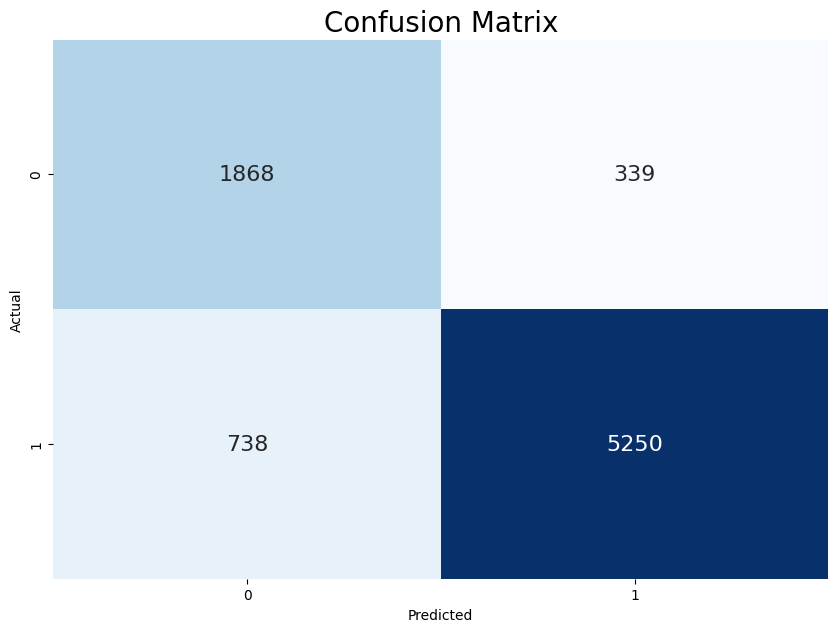

In [48]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=[0,1], index = [0,1])
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix', fontsize = 20)

sns.set(font_scale=1.4)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

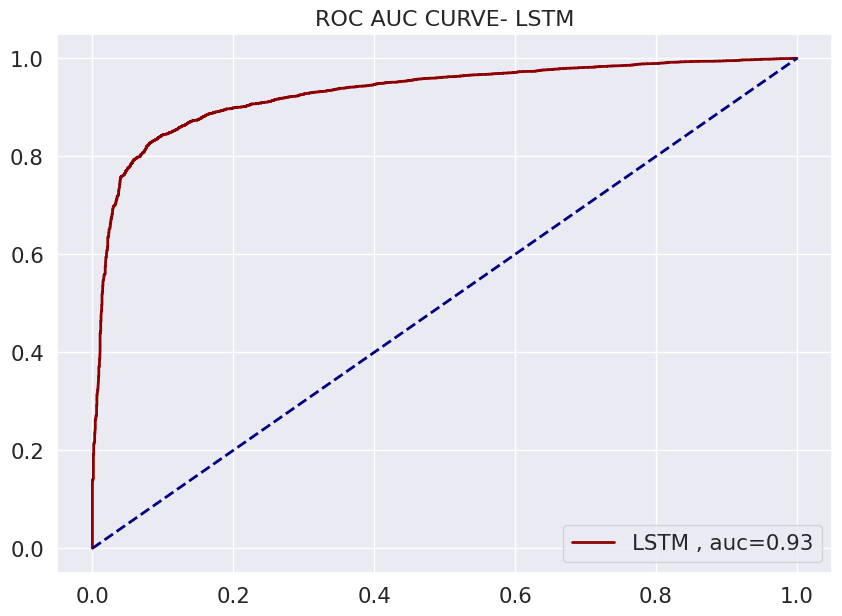

In [49]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds  = roc_curve(y_test, y_preds_prob)
auc = roc_auc_score(y_test, y_preds_prob)
plt.figure(figsize = (10,7))
plt.plot(fpr,tpr,color='darkred', lw=2, label="LSTM , auc="+str(round(auc,2)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC AUC CURVE- LSTM', fontsize = 16)
plt.legend(loc=4)
plt.show()

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
#logistic regression

In [51]:
lr = LogisticRegression(max_iter= MAX_ITER,random_state=RANDOM_STATE, n_jobs= N_JOBS)
lr.fit(X_train,y_train)
lr_preds = lr.predict(X_test)
print("Model score on Training Data = ", lr.score(X_train,y_train)*100,"%")
print("Model score on Testing Data = ", lr.score(X_test,y_test)*100,"%")

Model score on Training Data =  74.50430114086998 %
Model score on Testing Data =  73.32519829164124 %


In [ ]:
#naive bayes

In [52]:
nb = MultinomialNB()
nb.fit(X_train,y_train)
nb_preds = nb.predict(X_test)
print("Model score on Training Data = ", nb.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", nb.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  74.55615886767129 %
Model score on Testing Data =  74.35021354484441 %


In [ ]:
#svm

In [53]:
svm = SVC(random_state=RANDOM_STATE , verbose = True)
svm.fit(X_train,y_train)
sv_preds = svm.predict(X_test)
print("Model score on Training Data = ", svm.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", svm.score(X_test,y_test)*100 ,"%")

[LibSVM]Model score on Training Data =  79.7907388200842 %
Model score on Testing Data =  74.49664429530202 %


In [ ]:
#random forest

In [54]:
rfc = RandomForestClassifier(n_estimators = 100, random_state =RANDOM_STATE , n_jobs = N_JOBS)
rfc.fit(X_train,y_train)
rf_preds = rfc.predict(X_test)
print("Model score on Training Data = ", rfc.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", rfc.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  99.5790372765542 %
Model score on Testing Data =  78.40146430750458 %


In [ ]:
#xg boost

In [55]:
xgb = XGBClassifier(objective='binary:logistic' ,
                    use_label_encoder=False,
                    random_state = RANDOM_STATE,
                    eval_metric='mlogloss')
xgb.fit(X_train,y_train)
xg_preds = xgb.predict(X_test)
print("Model score on Training Data = ", xgb.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", xgb.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  93.8167286925752 %
Model score on Testing Data =  82.91641244661379 %


In [ ]:
#test accuracy

In [56]:
results = pd.DataFrame(data  = [accuracy*100] , columns =["NN-Lstm"] , index = ["Test Accuracy"])
results['Logistic Regression'] = lr.score(X_test,y_test)*100
results['Naive Bayes'] = nb.score(X_test,y_test)*100
results['Support Vector Machine (SVM)'] = svm.score(X_test,y_test)*100
results['RandomForest Classifier'] = rfc.score(X_test,y_test)*100
results['XGBoost Classifier'] = xgb.score(X_test,y_test)*100
results = results.transpose()
x = px.line(data_frame= results, y = ["Test Accuracy"] ,markers = True  )
x.update_xaxes(title="Model Name")
x.update_yaxes(title = "Test Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Test Accuracy comparison of all 6 models',
        'y':0.94,'x':0.5,'xanchor': 'center','yanchor': 'top'})
x.show()

In [ ]:
#confusion matrix

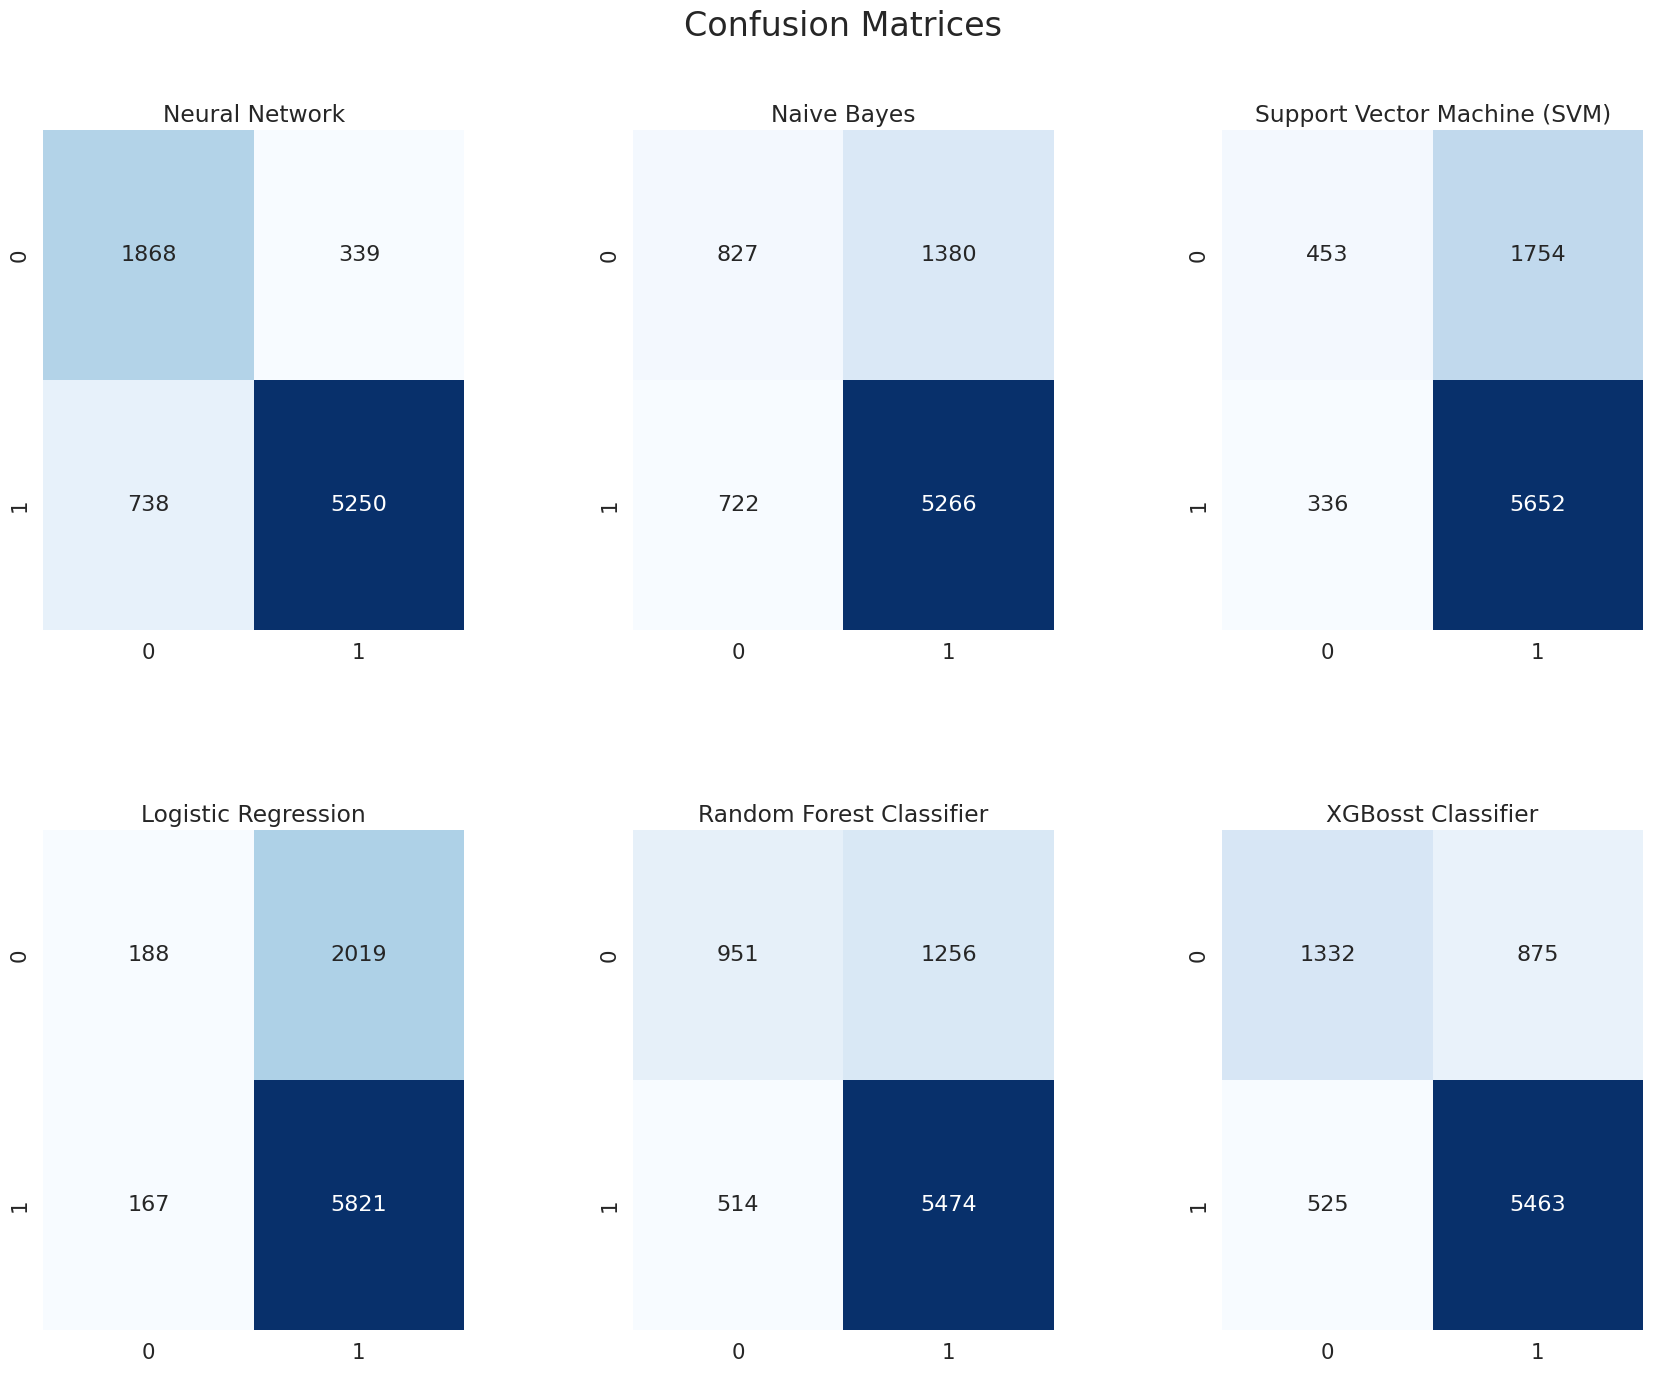

In [57]:
lr_cm=confusion_matrix(y_test, lr_preds )
nb_cm=confusion_matrix(y_test, nb_preds)
svm_cm=confusion_matrix(y_test, sv_preds)
nn_cm= confusion_matrix(y_test,y_preds)
rf_cm = confusion_matrix(y_test,rf_preds)
xg_cm = confusion_matrix(y_test,xg_preds)

plt.figure(figsize=(20,15))
plt.suptitle("Confusion Matrices",fontsize=24)

plt.subplot(2,3,1)
plt.title("Neural Network")
sns.heatmap(nn_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');


plt.subplot(2,3,2)
plt.title("Naive Bayes")
sns.heatmap(nb_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,3)
plt.title("Support Vector Machine (SVM)")
sns.heatmap(svm_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,4)
plt.title("Logistic Regression")
sns.heatmap(lr_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,5)
plt.title("Random Forest Classifier")
sns.heatmap(rf_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,6)
plt.title("XGBosst Classifier")
sns.heatmap(xg_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

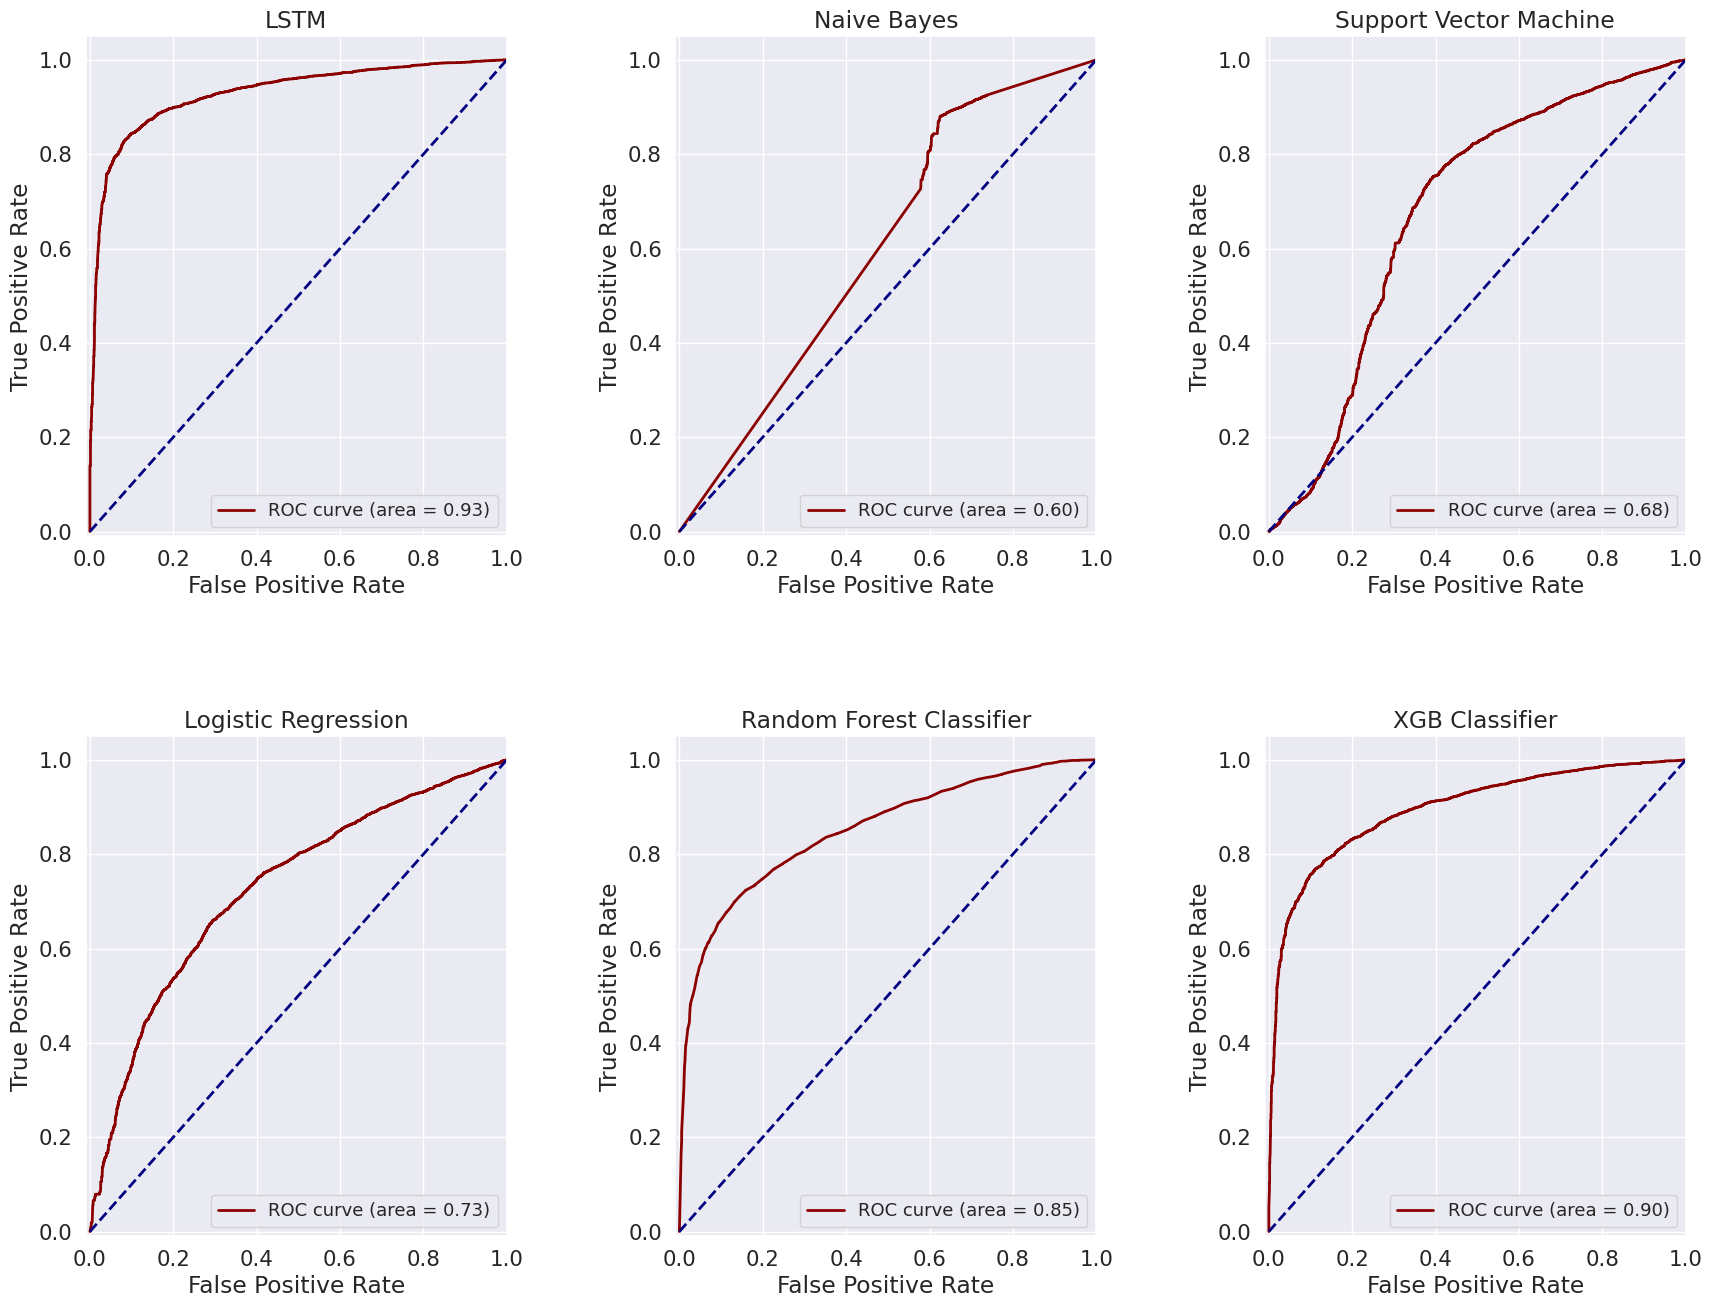

In [58]:
from sklearn.metrics import auc
pred_lr = lr.predict_proba(X_test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(y_test,pred_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)

pred_nb = nb.predict_proba(X_test)[:,1]
fpr_nb,tpr_nb,_ = roc_curve(y_test,pred_nb)
roc_auc_nb = auc(fpr_nb,tpr_nb)

pred_svm = svm.decision_function(X_test)
fpr_svm,tpr_svm,_ = roc_curve(y_test,pred_svm)
roc_auc_svm = auc(fpr_svm,tpr_svm)

fpr_nn, tpr_nn, _  = roc_curve(y_test, y_preds_prob)
roc_auc_nn = auc(fpr_nn,tpr_nn)

pred_rf = rfc.predict_proba(X_test)[:,1]
fpr_rf,tpr_rf,_ = roc_curve(y_test,pred_rf)
roc_auc_rf = auc(fpr_rf,tpr_rf)

pred_xg = xgb.predict_proba(X_test)[:,1]
fpr_xg,tpr_xg,_ = roc_curve(y_test,pred_xg)
roc_auc_xg = auc(fpr_xg,tpr_xg)

f, axes = plt.subplots(2,3,figsize=(20,15))
axes[0,0].plot(fpr_nn, tpr_nn, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nn))
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'LSTM')
axes[0,0].legend(loc='lower right', fontsize=13);


axes[0,1].plot(fpr_nb, tpr_nb, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nb))
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Naive Bayes')
axes[0,1].legend(loc='lower right', fontsize=13)

axes[0,2].plot(fpr_svm, tpr_svm, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_svm))
axes[0,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,2].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Support Vector Machine')
axes[0,2].legend(loc='lower right', fontsize=13)

axes[1,0].plot(fpr_lr, tpr_lr, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Logistic Regression')
axes[1,0].legend(loc='lower right', fontsize=13)


axes[1,1].plot(fpr_rf, tpr_rf, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_rf))
axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Random Forest Classifier')
axes[1,1].legend(loc='lower right', fontsize=13);


axes[1,2].plot(fpr_xg, tpr_xg, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_xg))
axes[1,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,2].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'XGB Classifier')
axes[1,2].legend(loc='lower right', fontsize=13);


plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)


In [ ]:
#x to 10x